In [28]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import pickle
from tqdm import tqdm
import torch.nn.utils as nn_utils
import numpy as np

In [29]:
class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -1.7,
        grid_max: float = 2.2,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -1.7,
        grid_max: float = 2.2,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: list[int],
        grid_min: float = -1.7,
        grid_max: float = 2.2,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [30]:
# Building Blocks for the Diffusion Model

# Sinusoidal time embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.embedding_dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.embedding_dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb 

# Diffusion Process and Sampling

def get_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

class Diffusion:
    def __init__(self, timesteps=1000, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.beta = get_beta_schedule(timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    def add_noise(self, x, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

def sample(model, diffusion, shape, device, save_all=0):
    model.eval()
    with torch.no_grad():
        x = torch.randn(shape, device=device)
        T = diffusion.timesteps
        for t in reversed(range(T)):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            epsilon = model(x, t_tensor)
            alpha_t = diffusion.alpha[t]
            alpha_bar_t = diffusion.alpha_bar[t]
            beta_t = diffusion.beta[t]
            alpha_bar_prev = diffusion.alpha_bar[t-1] if t > 0 else torch.tensor(1.0, device=device)
            sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t))
            mean = 1 / torch.sqrt(alpha_t) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon)
            noise = torch.randn_like(x) if t > 0 else 0
            x = mean + sigma_t * noise
            if save_all:
                save_all_timestep_images(x, T-t)
        return x

In [31]:
#Save all timestep images
def save_all_timestep_images(x, num):
    try:
        os.makedirs("timestep_images")
    except FileExistsError:
        pass

    grid2 = make_grid(torch.clamp(denormalize(x.clone().cpu()), 0.0, 1.0), nrow=4)
    
    save_image(grid2, f"/kaggle/working/timestep_images/not_scaled_{num}.png")

In [32]:
# Function to denormalize the images
def denormalize(tensor, 
                mean=torch.tensor([0.5062, 0.4256, 0.3830]).view(3, 1, 1), 
                std=torch.tensor([0.3035, 0.2831, 0.2826]).view(3, 1, 1)
               ):
    return tensor * std + mean

In [33]:
# Save model
def save_model(model, epoch):
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.state_dict(), f"diffusion_model_kanc_attention_epoch_{epoch}.pth")
    else:
        torch.save(model.state_dict(), f"diffusion_model_kanc_attention_epoch_{epoch}.pth")
    print("Model saved.")

# Save losses as a pickle file
def save_data(all_losses,last_batch_loss_per_epoch,avg_loss_per_epoch,epoch):
    
    with open(f'all_losses_{epoch}.pkl', 'wb') as f:
        pickle.dump(all_losses, f)
    
    with open(f'last_batch_loss_per_epoch_{epoch}.pkl', 'wb') as f:
        pickle.dump(last_batch_loss_per_epoch, f)
    
    with open(f'avg_loss_per_epoch_{epoch}.pkl', 'wb') as f:
        pickle.dump(avg_loss_per_epoch, f)
    
    print("Data Saved")

In [34]:
# Function to generate and display images
def display_samples(model, diffusion, device, epoch, n=16, figsize=(15,15), nrow=4, save=1, save_all=0):
    
    model.eval()
    with torch.no_grad():
        samples_2 = sample(model, diffusion, (n, 3, 64, 64), device, save_all=save_all)
        
    print("Before denorm:", samples_2.min().item(), samples_2.max().item())
    denorm_images_2 = denormalize(samples_2.cpu())
    print("After denorm:", denorm_images_2.min().item(), denorm_images_2.max().item())
    final_images_2 = torch.clamp(denorm_images_2, 0.0, 1.0)
    print("After clamping:", final_images_2.min().item(), final_images_2.max().item())
    
    grid2 = make_grid(final_images_2, nrow=nrow)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid2.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

    if save:
        save_image(grid2, f"generated_images_not_scaled_{epoch}.png")
        print("Images Saved")

In [35]:
# Hyperparameters

epochs = 5
batch_size = 128     
lr = 0.0005
timesteps = 1000
num_images = 202599
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay = 0.0007

torch.Size([128, 3, 64, 64])

After Normalization :



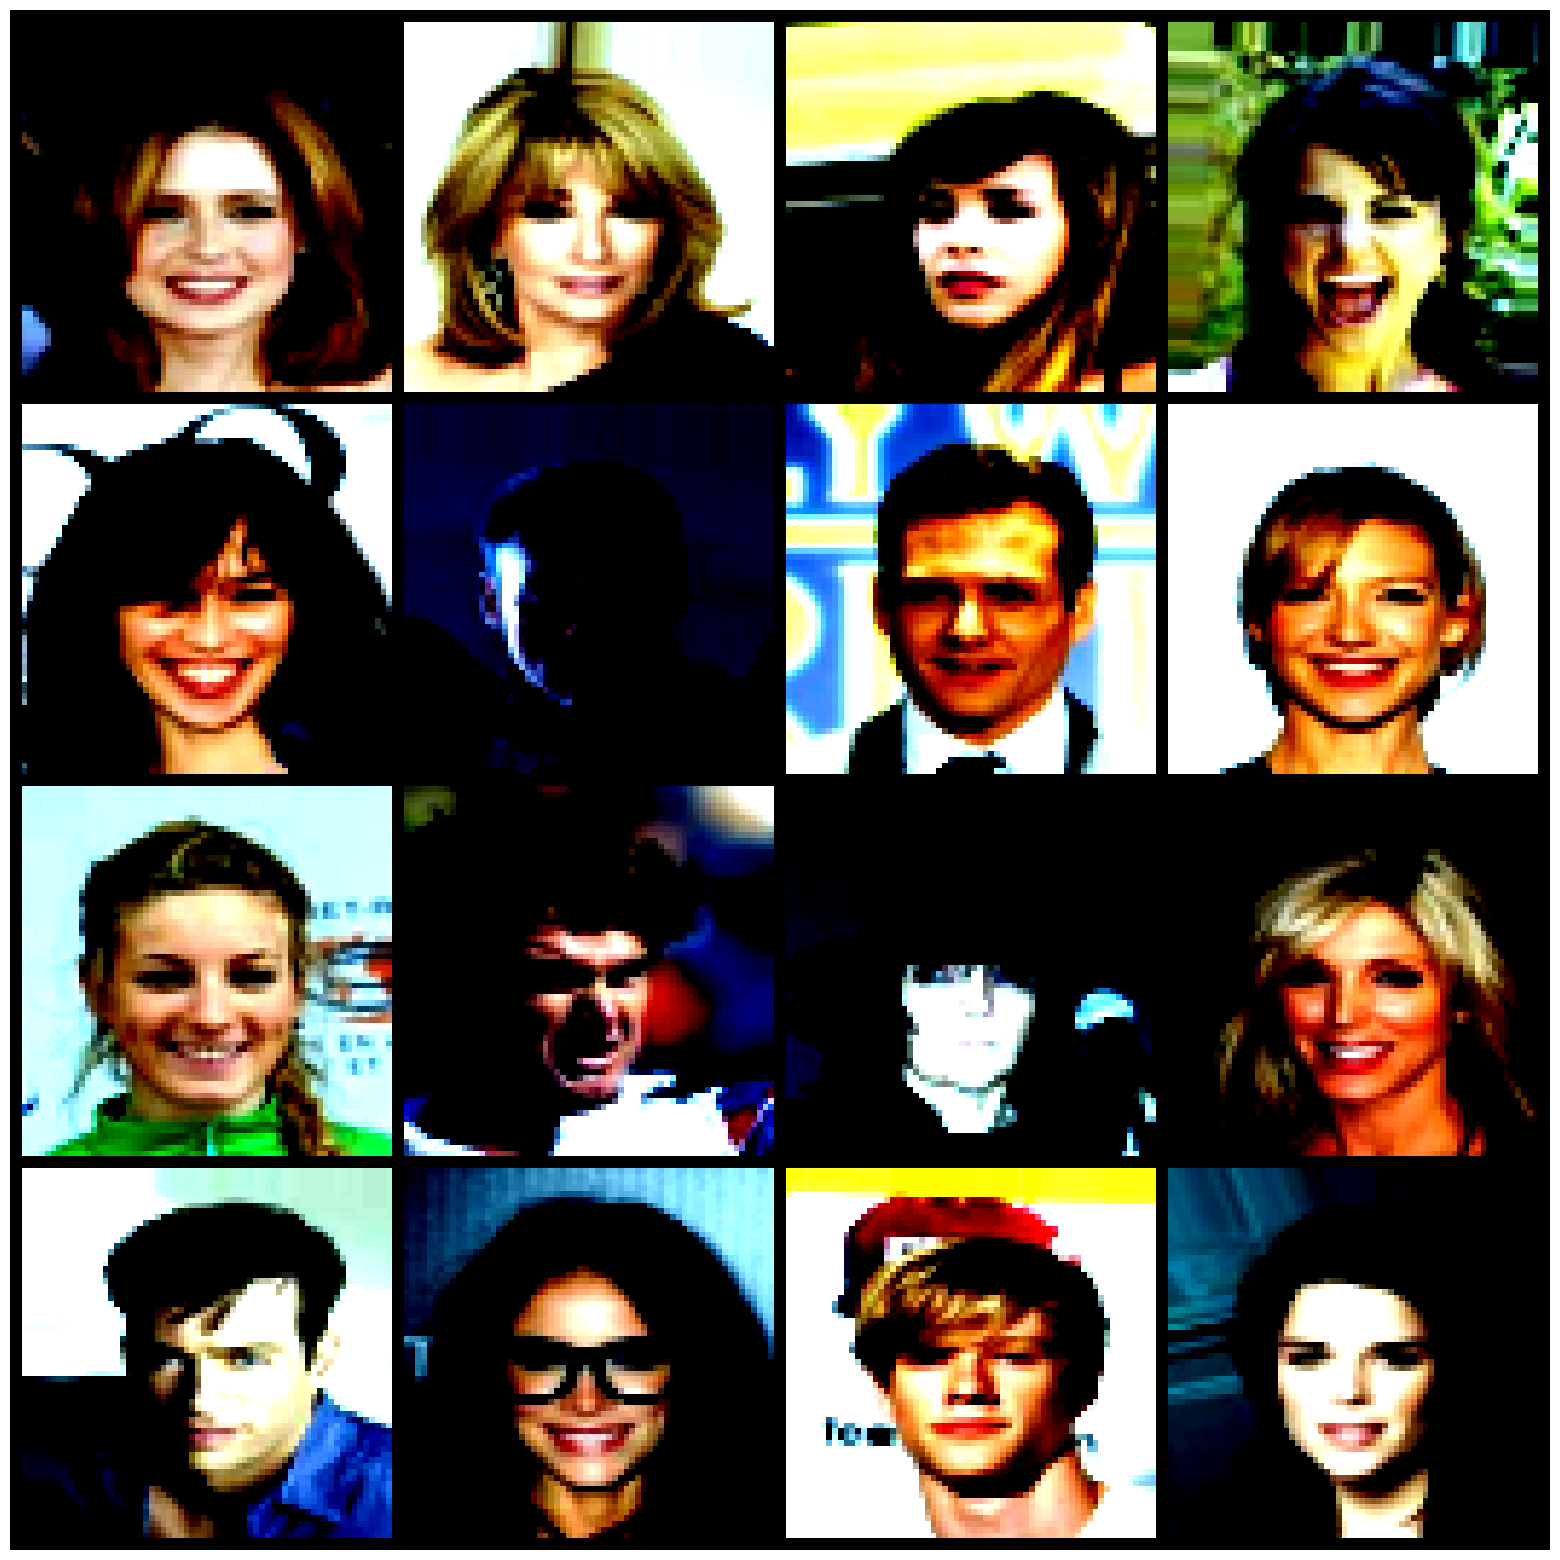


After Denormalization :



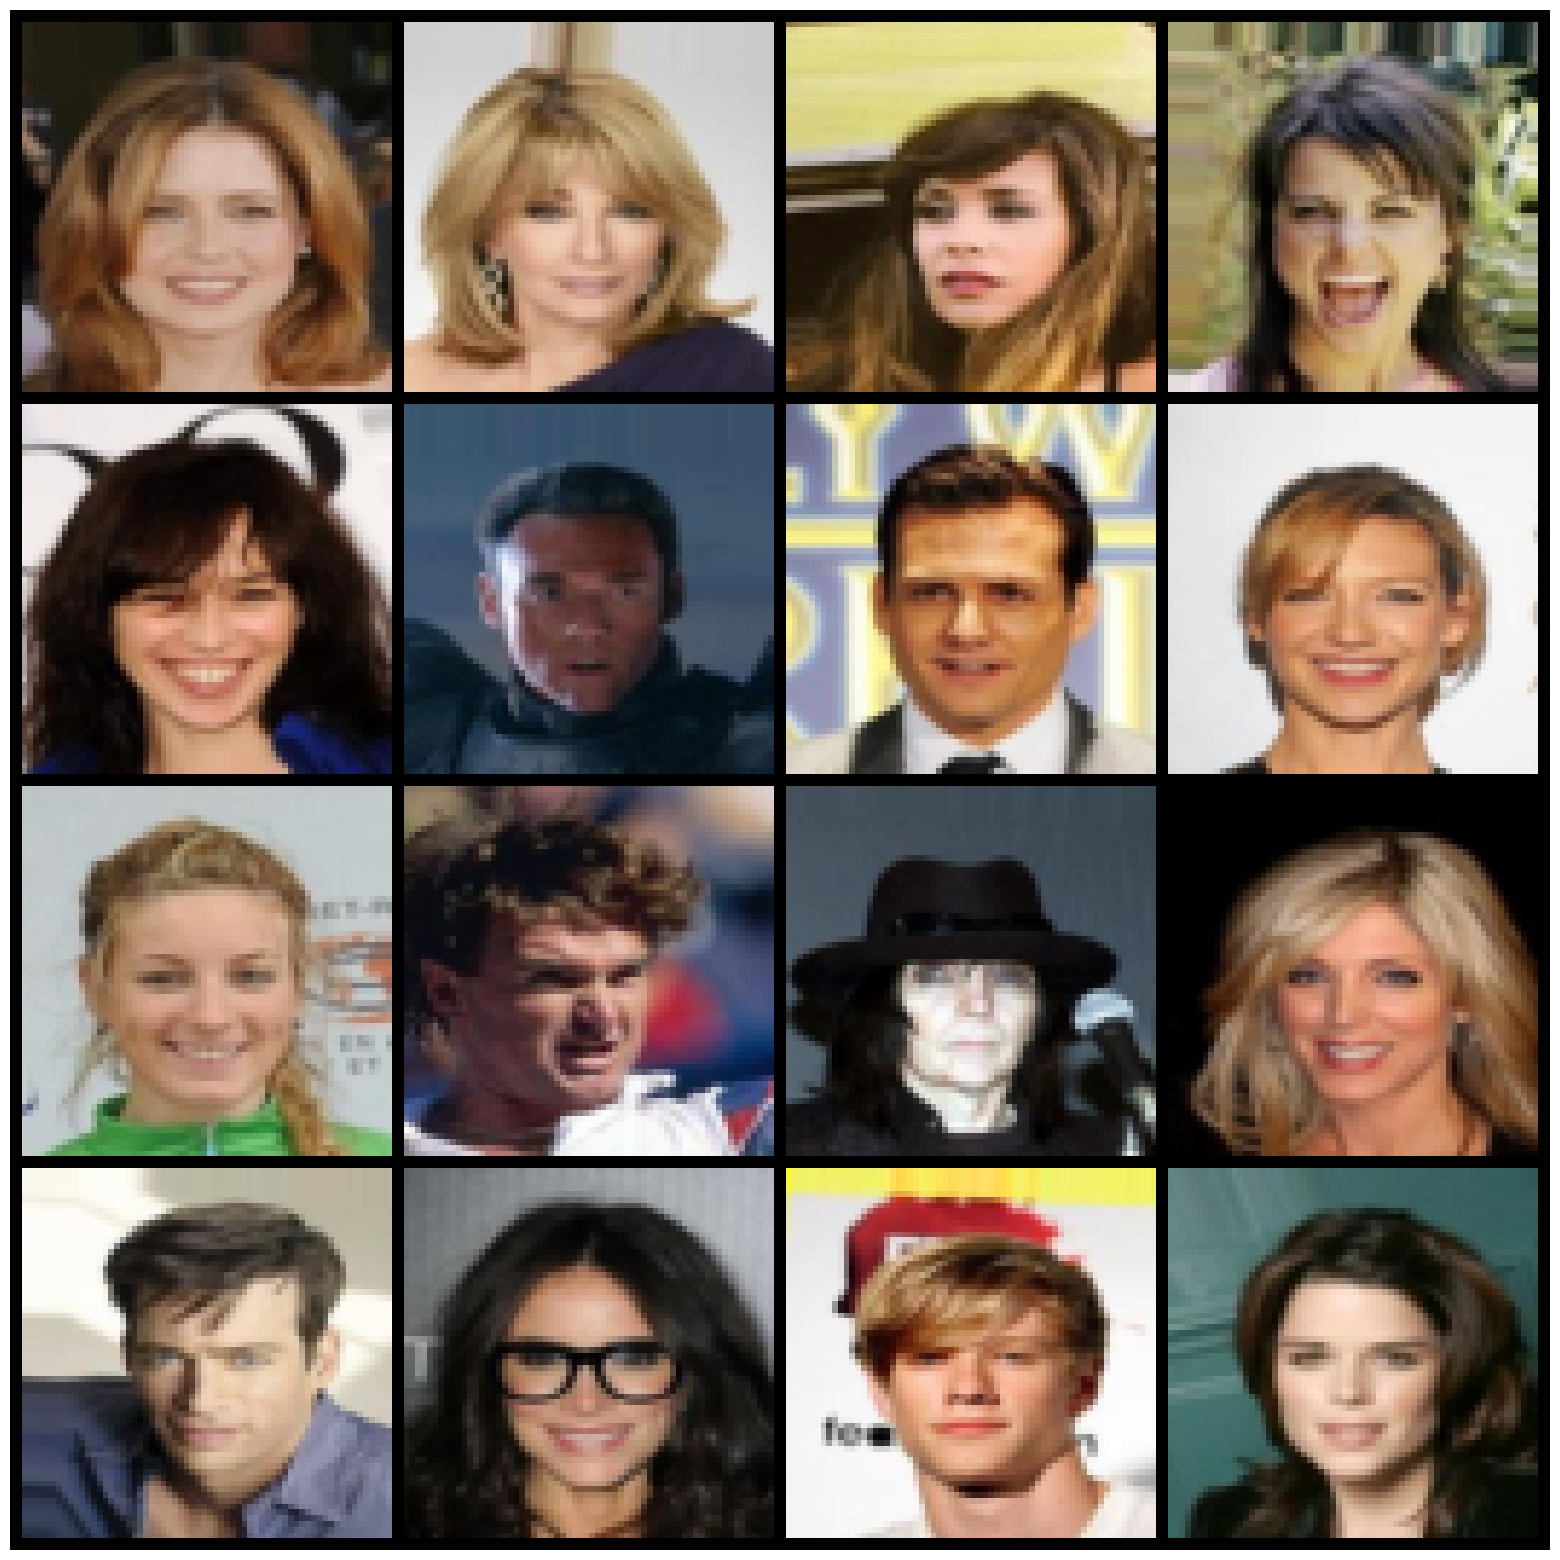

In [36]:
# CelebA Dataset Subset
class CelebASubset(Dataset):
    def __init__(self, root_dir, num_images, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(root_dir))[:num_images]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5062, 0.4256, 0.3830], std=[0.3035, 0.2831, 0.2826])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    
# Dataset folder address 
data_root = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebASubset(root_dir=data_root, num_images=num_images, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Testing the DataLoader
for images, _ in dataloader:
    print(images.size())
    break

# Fetch the first batch from the dataloader
data_iter = iter(dataloader)
images, _ = next(data_iter)  # images shape: [batch_size, 3, img_size, img_size]
    
# Retrieve the first ten images from the batch
first_images = images[0:16]
first_images_d = denormalize(first_images)
    
print('\nAfter Normalization :\n')
# Create Grid
grid = make_grid(first_images, nrow=4)
# Display the image
plt.figure(figsize=(20, 20))
# Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
first_images = grid.permute(1, 2, 0).numpy()
plt.imshow(first_images)
plt.axis('off')  # Hide axis
plt.show()

print('\nAfter Denormalization :\n')
# Create Grid
grid = make_grid(first_images_d, nrow=4)
# Display the image
plt.figure(figsize=(20, 20))
# Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
first_images = grid.permute(1, 2, 0).numpy()
plt.imshow(first_images)
plt.axis('off')
plt.show()

In [37]:
# Feature-wise affine conditioning (FiLM)
class FeatureWiseAffine(nn.Module):

    def __init__(self, in_channels, out_channels, use_affine_level=True):
        super().__init__()
        self.use_affine_level = use_affine_level

        linear_out = out_channels * (2 if use_affine_level else 1)
        self.noise_func = nn.Linear(in_channels, linear_out)

    def forward(self, x, noise_embed):

        B, C, H, W = x.shape

        proj = self.noise_func(noise_embed)        # (B, C*2) or (B, C)

        if self.use_affine_level:
            
            gamma, beta = proj.chunk(2, dim=1)     # each (B, C)
            # reshape to (B, C, 1, 1)
            gamma = gamma.view(B, C, 1, 1)
            beta  = beta.view(B, C, 1, 1)
            return (1 + gamma) * x + beta
        else:
            
            bias = proj.view(B, C, 1, 1)
            return x + bias

# Get group count
def get_num_groups(channels, max_groups=8):
    g = min(channels, max_groups)
    while channels % g != 0 and g > 1:
        g -= 1
    return max(1, g)

# Residual Block with FiLM conditioning
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.norm1 = nn.GroupNorm(get_num_groups(in_ch), in_ch)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        
        self.norm2 = nn.GroupNorm(get_num_groups(out_ch), out_ch)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        
        self.proj = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else None
        
        self.film = FeatureWiseAffine(time_emb_dim, out_ch) if time_emb_dim else None

    def forward(self, x, t_emb=None):
        out = self.conv1(self.act1(self.norm1(x)))
        out = self.conv2(self.act2(self.norm2(out)))
        if self.film and t_emb is not None:
            out = self.film(out, t_emb)
        skip = self.proj(x) if self.proj else x
        return out + skip

class SelfAttention(nn.Module):
    def __init__(self, groups, channels):
        super().__init__()
        self.norm = nn.GroupNorm(groups, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1)  # (B, C, H*W)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)
        attn = torch.bmm(q.permute(0, 2, 1), k)  # (B, H*W, H*W)
        attn = attn * (C ** -0.5)
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        out = self.proj_out(out)
        return out
        
class AttnBlock(nn.Module):
    def __init__(self, groups, channels):
        super().__init__()
        
        self.attn = SelfAttention(groups, channels)
        
    def forward(self, x):
        return x + self.attn(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.res = ResBlock(in_ch, out_ch, time_emb_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)
    def forward(self, x, t_emb):
        return self.down(self.res(x, t_emb))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.res = ResBlock(in_ch, out_ch, time_emb_dim)
    def forward(self, x, skip, t_emb):
        x = self.up(x)
        dh = skip.size(2)-x.size(2); dw = skip.size(3)-x.size(3)
        if dh or dw:
            x = F.pad(x, [dw//2, dw-dw//2, dh//2, dh-dh//2])
        return self.res(torch.cat([x, skip],1), t_emb)

class DiffusionUNet(nn.Module):
    def __init__(self, time_emb_dim, in_channels, base_channels, out_channels):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            FastKAN([time_emb_dim, time_emb_dim*4, time_emb_dim])
        )
        
        self.init = ResBlock(in_channels, base_channels, time_emb_dim)
        
        # Encoder
        self.down1 = Down(base_channels, base_channels*2, time_emb_dim)
        self.down2 = Down(base_channels*2, base_channels*4, time_emb_dim)
        self.down3 = Down(base_channels*4, base_channels*8, time_emb_dim)
        self.down4 = Down(base_channels*8, base_channels*16, time_emb_dim)
        self.attn3 = AttnBlock(8, base_channels*8)
        self.attn4 = AttnBlock(8, base_channels*16)

        dim_flat = base_channels*16*4*4
        self.fastkan = FastKAN([dim_flat + time_emb_dim, 50, 50, dim_flat])     
        self.attn_bottleneck = AttnBlock(8, base_channels*16)
   

        # Decoder with in_ch = skip + x channels
        self.up4 = Up(base_channels*16 + base_channels*8, base_channels*8, time_emb_dim)
        self.up3 = Up(base_channels*8 +  base_channels*4, base_channels*4, time_emb_dim)
        self.up2 = Up(base_channels*4 +  base_channels*2, base_channels*2, time_emb_dim)
        self.up1 = Up(base_channels*2 +  base_channels,   base_channels,   time_emb_dim)
        self.attn_up4 = AttnBlock(8, base_channels*8)
        self.attn_up3 = AttnBlock(8, base_channels*4)
        
        self.final_res = ResBlock(base_channels, base_channels, time_emb_dim)
        self.final = nn.Conv2d(base_channels, out_channels, 1)

    def forward(self, x, t):
        
        t_emb = self.time_mlp(t)
        
        x0 = self.init(x, t_emb)
        x1 = self.down1(x0, t_emb)
        x2 = self.down2(x1, t_emb)
        x3 = self.attn3(self.down3(x2, t_emb))
        x4 = self.attn4(self.down4(x3, t_emb))

        B,C,H,W = x4.shape
        flat = x4.view(B, -1)
        flat = self.fastkan(torch.cat([flat, t_emb],1))
        xb = flat.view(B, C, H, W)
        #xb = self.bottleneck1(x4, t_emb)
        xb = self.attn_bottleneck(xb)
        #xb = self.bottleneck1(xb, t_emb)

        x = self.attn_up4(self.up4(xb, x3, t_emb))
        x = self.attn_up3(self.up3(x,  x2, t_emb))
        x = self.up2(x, x1, t_emb)
        x = self.up1(x, x0, t_emb)
        return self.final(self.final_res(x, t_emb))

In [38]:
# Initialize the model
model = DiffusionUNet(in_channels=3, out_channels=3, base_channels=32, time_emb_dim=256)

In [39]:
model

DiffusionUNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): FastKAN(
      (layers): ModuleList(
        (0): FastKANLayer(
          (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (rbf): RadialBasisFunction()
          (spline_linear): SplineLinear(in_features=2048, out_features=1024, bias=False)
          (base_linear): Linear(in_features=256, out_features=1024, bias=True)
        )
        (1): FastKANLayer(
          (layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (rbf): RadialBasisFunction()
          (spline_linear): SplineLinear(in_features=8192, out_features=256, bias=False)
          (base_linear): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
    )
  )
  (init): ResBlock(
    (norm1): GroupNorm(3, 3, eps=1e-05, affine=True)
    (act1): SiLU()
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(8, 32, eps=1e-05, af

In [40]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 29608801
Trainable parameters: 29608761


In [41]:
epoch = 60

In [42]:
# Load the saved model state
result = model.load_state_dict(torch.load(f"diffusion_model_kanc_attention_epoch_{epoch}.pth",map_location=device, weights_only=False), strict=False)

#result = model.load_state_dict(torch.load(f"/kaggle/input/epoch-20/diffusion_model_kanc_attention_epoch_20.pth", map_location=device, weights_only=False), strict=False)


# Load a smaller model into a larger model
# Load the checkpoint
checkpoint_state = torch.load(f"diffusion_model_kanc_attention_epoch_{epoch}.pth",map_location=device, weights_only=False)

#checkpoint_state = torch.load(f"/kaggle/input/epoch-20/diffusion_model_kanc_attention_epoch_20.pth",map_location=device, weights_only=False)

# Get the state dict of the larger model
big_state = model.state_dict()

# Filter out only the parameters that match in key and shape
filtered_state = {}
for key, value in checkpoint_state.items():
    if key in big_state:
        if big_state[key].size() == value.size():
            filtered_state[key] = value
        else:
            print(f"Skipping {key} due to size mismatch: checkpoint {value.size()} vs model {big_state[key].size()}")
    else:
        print(f"Key {key} not found in the big model.")

# Update the big model state with the filtered checkpoint parameters
big_state.update(filtered_state)

# Load the filtered state dict into the big model
result = model.load_state_dict(big_state, strict=False)



# Load a larger model into a smaller model
# Load the checkpoint from the larger model
#checkpoint_state = torch.load(f"diffusion_model_kanc_attention_epoch_{epoch}.pth",
#                              map_location=device, weights_only=False)
checkpoint_state = torch.load(f"/kaggle/input/epoch-17/diffusion_model_kanc_attention_epoch_17.pth",map_location=device, weights_only=False)

# Get the state dict of the smaller model
small_state = model.state_dict()  # 'model' here is the smaller model

# Filter out only the parameters from the larger model that match in key and shape in the smaller model
filtered_state = {}
for key, value in checkpoint_state.items():
    if key in small_state:
        if small_state[key].size() == value.size():
            filtered_state[key] = value
        else:
            print(f"Skipping {key} due to size mismatch: checkpoint {value.size()} vs model {small_state[key].size()}")
    else:
        print(f"Key {key} not found in the smaller model.")

# Update the smaller model state with the filtered checkpoint parameters
small_state.update(filtered_state)

# Load the filtered state dict into the smaller model
result = model.load_state_dict(small_state)


epoch = 0

# Track losses
all_losses = []
avg_loss_per_epoch = []
last_batch_loss_per_epoch = []

In [43]:
# Load from pickle files
with open(f'/kaggle/working/all_losses_{epoch}.pkl', 'rb') as f:
    all_losses = pickle.load(f)
with open(f'/kaggle/working/avg_loss_per_epoch_{epoch}.pkl', 'rb') as f:
    avg_loss_per_epoch = pickle.load(f)
with open(f'/kaggle/working/last_batch_loss_per_epoch_{epoch}.pkl', 'rb') as f:
    last_batch_loss_per_epoch = pickle.load(f)

In [44]:
print(len(all_losses), len(avg_loss_per_epoch), len(last_batch_loss_per_epoch), epoch)

94980 60 60 60


In [45]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [46]:
model

DataParallel(
  (module): DiffusionUNet(
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): FastKAN(
        (layers): ModuleList(
          (0): FastKANLayer(
            (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (rbf): RadialBasisFunction()
            (spline_linear): SplineLinear(in_features=2048, out_features=1024, bias=False)
            (base_linear): Linear(in_features=256, out_features=1024, bias=True)
          )
          (1): FastKANLayer(
            (layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (rbf): RadialBasisFunction()
            (spline_linear): SplineLinear(in_features=8192, out_features=256, bias=False)
            (base_linear): Linear(in_features=1024, out_features=256, bias=True)
          )
        )
      )
    )
    (init): ResBlock(
      (norm1): GroupNorm(3, 3, eps=1e-05, affine=True)
      (act1): SiLU()
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), st

In [47]:
model = model.to(device)

In [48]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [49]:
# Initialize the diffusion process
diffusion = Diffusion(timesteps=timesteps, device=device)
#diffusion = Diffusion(timesteps=900, device=device)

In [ ]:
# Training Loop

# Using mixed-precision training
scaler = torch.amp.GradScaler("cuda")

# Initialize the global timestep counter
#global_t = timesteps-1

# Training mode
model.train()

for i in range(epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [{i+1}/{epochs}]")
    avg = 0.0
    num = 0
    for images, _ in progress_bar:
        
        images = images.to(device, non_blocking=True)
        current_batch_size = images.shape[0]
        
        t = torch.randint(0, timesteps, (current_batch_size,), device=device).long()
        # Generate descending sequence of timesteps using modulo arithmetic
        #t_values = [(global_t - i) % timesteps for i in range(current_batch_size)]
        #t = torch.tensor(t_values, device=device, dtype=torch.long)

        # Update the global timestep counter using modulo arithmetic.
        #global_t = (global_t - current_batch_size) % timesteps
        
        noisy_images, noise = diffusion.add_noise(images, t)
            
        optimizer.zero_grad()
        
        with torch.amp.autocast("cuda"):
            
            predicted_noise = model(noisy_images, t)
            loss = F.mse_loss(predicted_noise, noise)

        #loss.backward()
        scaler.scale(loss).backward()
        
        nn_utils.clip_grad_norm_(model.parameters(), max_norm=5.0) 
        #optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        avg += loss.item()
        num += 1
        all_losses.append(loss.item())
        
        #if loss.item() > 0.03:
            #print((global_t + current_batch_size)%timesteps)
            
        progress_bar.set_postfix({"Current Loss": loss.item(), "Current Avg. Loss": avg/num})
        
    last_batch_loss_per_epoch.append(loss.item())
    avg_loss_per_epoch.append(avg/num)
    
    print(f"Epoch {epoch+1} [{i+1}/{epochs}] Last Batch Loss: {loss.item():.5f}, Avg. Loss = {avg_loss_per_epoch[-1]:.5f}")
    
    # Save model and data
    save_model(model, epoch+1)
    save_data(all_losses, last_batch_loss_per_epoch, avg_loss_per_epoch, epoch+1)
    epoch+=1
    
print("Training Completed")

In [50]:
#save_model(model, epoch)
#save_data(all_losses, last_batch_loss_per_epoch, avg_loss_per_epoch, epoch)

In [51]:
print(len(all_losses), len(avg_loss_per_epoch), len(last_batch_loss_per_epoch), epoch)

94980 60 60 60


Before denorm: -1.7081332206726074 2.402869462966919
After denorm: -0.01985102891921997 1.0620508193969727
After clamping: 0.0 1.0


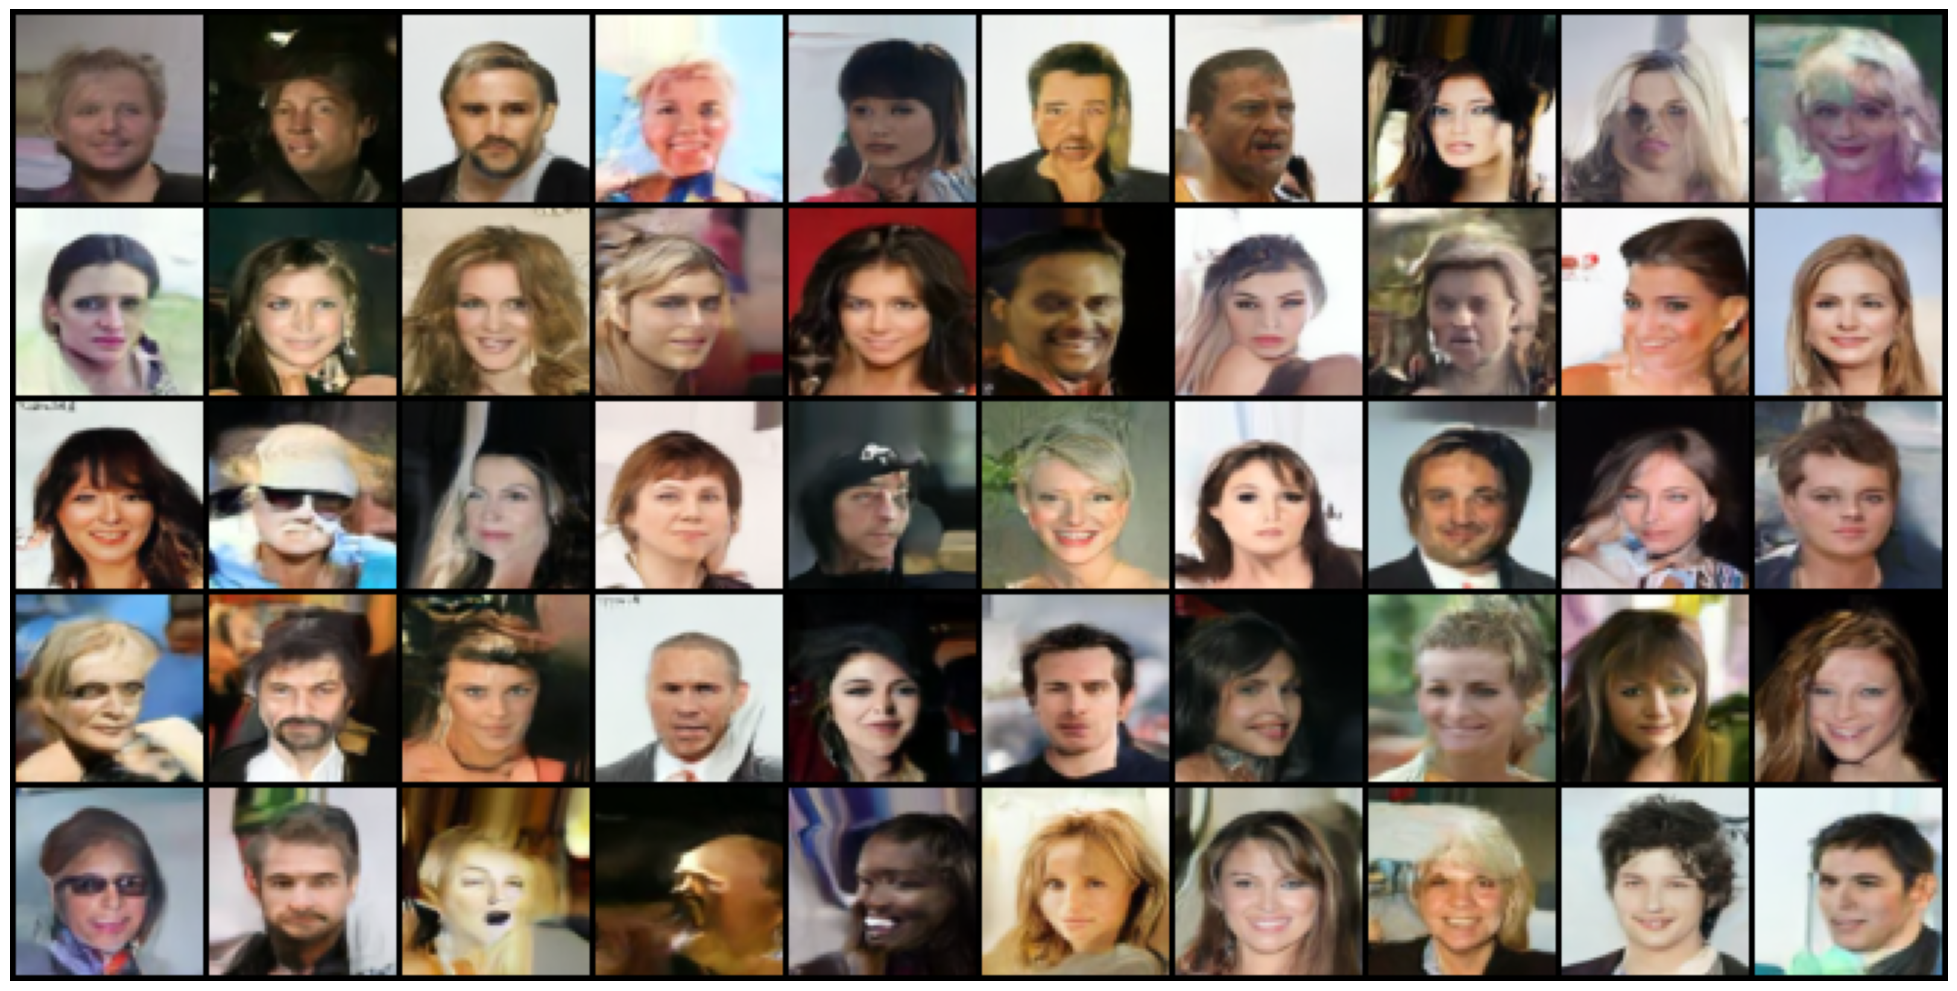

Images Saved


In [52]:
# Generate and display images
display_samples(model, diffusion, device, epoch, n=50, figsize=(25,25),nrow=10, save=1, save_all=0)

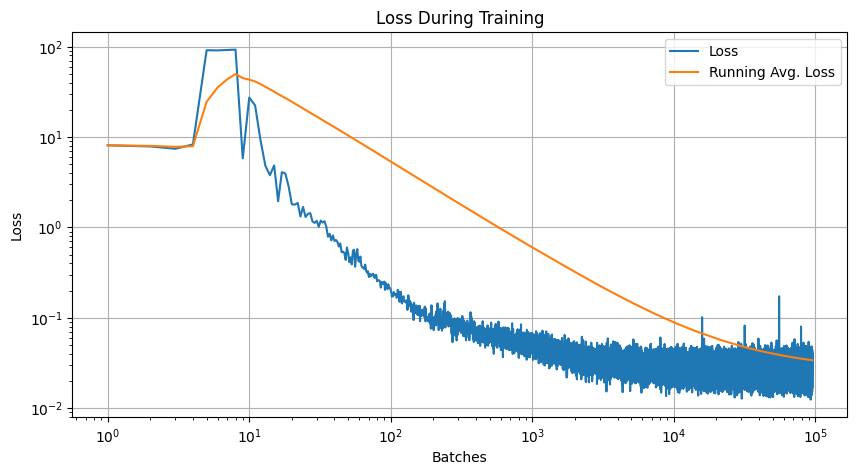

In [53]:
# Calculate running average
cumsum_all_losses = np.cumsum(all_losses)
indices = np.arange(1, len(all_losses) + 1)
running_avg_all_losses = cumsum_all_losses/indices

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(indices, all_losses, label='Loss')
plt.plot(indices, running_avg_all_losses, label='Running Avg. Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.title('Loss During Training')
plt.grid(True)
plt.legend()
plt.show()

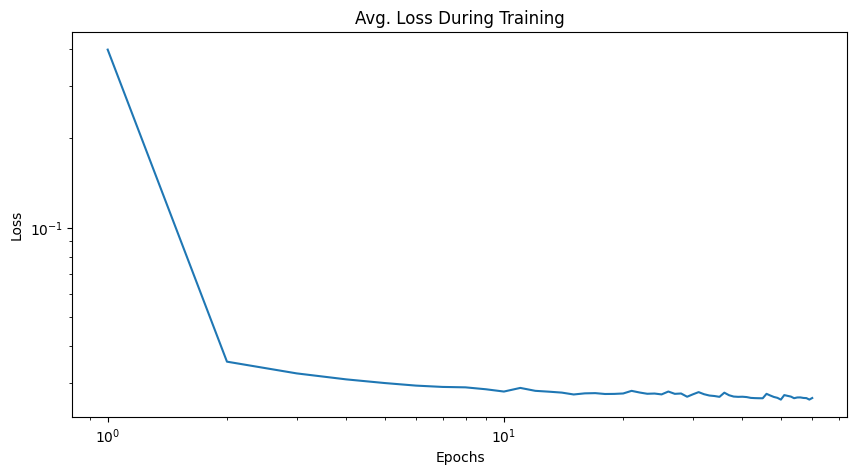

In [54]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,len(avg_loss_per_epoch)+1), avg_loss_per_epoch, label='Avg Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.title('Avg. Loss During Training')
#plt.legend()
plt.show()

In [55]:
# Calculating FID and Inception Score
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import Subset
from scipy import linalg

num_real = 512
indices = torch.randperm(len(dataset))[:num_real]
real_subset = Subset(dataset, indices)
real_loader = DataLoader(real_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

weights = Inception_V3_Weights.DEFAULT
incept = inception_v3(weights=weights, aux_logits=True, transform_input=False).to(device)
incept.eval()

def get_features(x):
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        x = incept.Conv2d_1a_3x3(x)
        x = incept.Conv2d_2a_3x3(x)
        x = incept.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = incept.Conv2d_3b_1x1(x)
        x = incept.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = incept.Mixed_5b(x)
        x = incept.Mixed_5c(x)
        x = incept.Mixed_5d(x)
        x = incept.Mixed_6a(x)
        x = incept.Mixed_6b(x)
        x = incept.Mixed_6c(x)
        x = incept.Mixed_6d(x)
        x = incept.Mixed_6e(x)
        x = incept.Mixed_7a(x)
        x = incept.Mixed_7b(x)
        x = incept.Mixed_7c(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
    return x.view(x.size(0), -1)

def get_inception_preds(x):
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        out = incept(x)
    # handle whichever format is returned
    if isinstance(out, tuple):
        logits = out[0]
    elif hasattr(out, 'logits'):
        logits = out.logits
    else:
        logits = out
    return F.softmax(logits, dim=1)

@torch.no_grad()
def generate_fake(batch_size):
    z = sample(model, diffusion, (batch_size,3,64,64), device)
    img = denormalize(z.cpu()).clamp(0,1).to(device)
    return img

def compute_fid_and_is(model, diffusion, device, real_loader,
                      num_samples=5120, batch_size=128, splits=10):
    real_feats = []
    for imgs, _ in tqdm(real_loader, desc="Real → feats"):
        mean = torch.tensor([0.5062,0.4256,0.3830]).view(1,3,1,1)
        std  = torch.tensor([0.3035,0.2831,0.2826]).view(1,3,1,1)
        x = torch.clamp(imgs.cpu()*std + mean,0,1).to(device)
        real_feats.append(get_features(x).cpu().numpy())
    real_feats = np.concatenate(real_feats, axis=0)

    fake_feats = []
    preds = []
    n_iters = (num_samples + batch_size - 1)//batch_size
    for _ in tqdm(range(n_iters), desc="Fake → feats & preds"):
        x = generate_fake(batch_size)
        fake_feats.append(get_features(x).cpu().numpy())
        preds.append(get_inception_preds(x).cpu().numpy())
    fake_feats = np.concatenate(fake_feats, axis=0)[:num_samples]
    preds = np.concatenate(preds, axis=0)[:num_samples]

    mu_r, sigma_r = real_feats.mean(0), np.cov(real_feats, rowvar=False)
    mu_g, sigma_g = fake_feats.mean(0), np.cov(fake_feats, rowvar=False)
    diff = mu_r - mu_g
    covmean = linalg.sqrtm(sigma_r.dot(sigma_g))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_val = diff.dot(diff) + np.trace(sigma_r + sigma_g - 2*covmean)

    split_size = num_samples // splits
    scores = []
    for i in range(splits):
        part = preds[i*split_size:(i+1)*split_size]
        py = part.mean(0, keepdims=True)
        kl = part * (np.log(part) - np.log(py))
        scores.append(np.exp(kl.sum(1).mean()))
    is_mean, is_std = float(np.mean(scores)), float(np.std(scores))

    return float(fid_val), is_mean, is_std

model.eval()
fid_score, is_mean, is_std = compute_fid_and_is(
    model, diffusion, device, real_loader,
    num_samples=num_real, batch_size=batch_size, splits=10
)
print(f"FID: {fid_score:.4f}")
print(f"IS : {is_mean:.4f} ± {is_std:.4f}")
print('Epoch :',epoch)

Fake → feats & preds: 100%|██████████| 4/4 [08:09<00:00, 122.48s/it]


FID: 37.9044
IS : 2.2039 ± 0.1364
Epoch : 60


# Extra codes below:

def sample_2(model, diffusion, shape, device):
    model.eval()
    with torch.no_grad():
        x = torch.randn(shape, device=device)
        T = diffusion.timesteps
        img = []
        for t in reversed(range(T)):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            epsilon = model(x, t_tensor)
            alpha_t = diffusion.alpha[t]
            alpha_bar_t = diffusion.alpha_bar[t]
            beta_t = diffusion.beta[t]
            alpha_bar_prev = diffusion.alpha_bar[t-1] if t > 0 else torch.tensor(1.0, device=device)
            sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t))
            mean = 1 / torch.sqrt(alpha_t) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon)
            noise = torch.randn_like(x) if t > 0 else 0
            x = mean + sigma_t * noise
            if T-t in {1000,900,800,700,600,500,400,300,200,100,1}:
                img.append(x.clone())
        return img

def return_sample(model, diffusion, device, epoch):
    final = []
    while len(final) != 5:
        
        model.eval()
        with torch.no_grad():
            samples = sample_2(model, diffusion, (1, 3, 64, 64), device)
            
            samples = torch.cat(samples, dim=0)
            print(samples.shape)
            samples_2 = samples.clone()
            print(samples_2.shape)
            
        print("Before denorm:", samples_2.min().item(), samples_2.max().item())
        denorm_images_2 = denormalize(samples_2.cpu())
        print("After denorm:", denorm_images_2.min().item(), denorm_images_2.max().item())
        final_images_2 = torch.clamp(denorm_images_2, 0.0, 1.0)
        print("After clamping:", final_images_2.min().item(), final_images_2.max().item())
        
        grid2 = make_grid(final_images_2, nrow=11)
        
        plt.figure(figsize=(20,10))
        plt.imshow(grid2.permute(1, 2, 0).numpy())
        plt.axis("off")
        plt.show()
        if input('add??')=='yes':
            final.append(samples)
    return final

x = return_sample(model, diffusion, device, epoch)

x1 = torch.clamp(denormalize(torch.cat(x).view(5,11,3,64,64).cpu()),0.0,1.0).view(-1,3,64,64)
print(x1.shape)
grid2 = make_grid(x1, nrow=11)

save_image(grid2, "Final Variant 3.png")
plt.figure(figsize=(20,50))
plt.imshow(grid2.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# Function to generate and display images
def display_samples_check(model, d_n, device, n=16, figsize=(15,15), nrow=4, save=1):
    
    diffusion = Diffusion(timesteps=d_n, device=device)
    
    model.eval()
    with torch.no_grad():
        samples = sample(model, diffusion, (n, 3, 64, 64), device, save_all=0)
        samples_2 = samples.clone()
        
    
    print("*********** Scaled Version ***********")
    print("Before scaling:", samples.min().item(), samples.max().item())
    output_scaler = OutputScaler().to(device)
    scaled = output_scaler(samples)
    print("Before denorm:", scaled.min().item(), scaled.max().item())
    denorm_images = denormalize(scaled.cpu())
    print("After denorm:", denorm_images.min().item(), denorm_images.max().item())
    final_images = torch.clamp(denorm_images, 0.0, 1.0)
    print("After clamping:", final_images.min().item(), final_images.max().item())
    
    grid = make_grid(final_images, nrow=nrow)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

    print("\n\n\n*********** Not Scaled Version ***********")
    print("Before denorm:", samples_2.min().item(), samples_2.max().item())
    denorm_images_2 = denormalize(samples_2.cpu())
    print("After denorm:", denorm_images_2.min().item(), denorm_images_2.max().item())
    final_images_2 = torch.clamp(denorm_images_2, 0.0, 1.0)
    print("After clamping:", final_images_2.min().item(), final_images_2.max().item())
    
    grid2 = make_grid(final_images_2, nrow=nrow)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid2.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

    if save:
        save_image(grid, f"check/generated_images_scaled_{d_n}.png")
        save_image(grid2, f"check/generated_images_not_scaled_{d_n}.png")
        print(f"Images Saved {d_n}")

for i in range(100,1001,100):
    display_samples_check(model, i, device, n=16, figsize=(16,16),nrow=4, save=1)

# Calculating mean and standard deviation
import torch
from torchvision import transforms

from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset

class CelebASubset(Dataset):
    def __init__(self, root_dir, num_images, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(root_dir))[:num_images]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0
        
# Function to compute dataset mean and std
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    total_samples = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (number of images)
        images = images.view(batch_samples, images.size(1), -1)  # Flatten spatial dimensions
        mean += images.mean([0, 2]) * batch_samples
        std += images.std([0, 2]) * batch_samples
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std

# Define a dataset without normalization
transform_no_norm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
num_images = 200000
data_root = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebASubset(root_dir=data_root, num_images=num_images, transform=transform_no_norm)

# Compute mean and std
mean, std = compute_mean_std(dataset)
print("Mean:", mean)
print("Std:", std)
